In [1]:
import copy
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm, trange

sys.path.append("../..")
from loss import bc_derivative_mse, pde_mse
from model import Model
from preprocess import preprocess
from trainer import train_bc, train_ic, train_pde_data, validate
from scheduler import CosineScheduler

from burgers.plot import plot_2d
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
device = torch.device("cuda:2")

In [2]:
test_id = "IC_train"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(1.), tensor(1.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...
Name: 0, dtype: object

In [3]:
xyt, true_field, nu = preprocess(data)  # Change to grid format
# xyt = xyt[:, :, :int(xyt.shape[2] / 2), :]
# true_field = true_field[:int(true_field.shape[0] / 2), ...]

ic_sparsity = 1.0  # Sparsity of choosing grid points for initial condition
bc_sparsity = 0.1  # Sparsity of choosing grid points for boundary condition
pde_sparsity = 0.001  # Sparsity of choosing grid points for PDE condition
data_sparsity = 0.001  # Sparsity of choosing grid points for data condition
val_sparsity = 0.1  # Sparsity of choosing grid points for validation

# Full data
# Initial condition
ic_x = xyt[..., 0, 0].reshape(-1, 1)
ic_y = xyt[..., 0, 1].reshape(-1, 1)
ic_t = torch.zeros_like(ic_x)
ic_field = true_field[0].reshape(-1, 2)
num_ic = int(ic_sparsity * len(ic_x))

# Boundary condition. bc1: left, bottom, bc2: right, top
bc_x1 = torch.cat((xyt[0, :, :, 0], xyt[1:, 0, :, 0]), dim=0).reshape(-1, 1)
bc_y1 = torch.cat((xyt[0, :, :, 1], xyt[1:, 0, :, 1]), dim=0).reshape(-1, 1)
bc_t1 = torch.cat((xyt[0, :, :, 2], xyt[1:, 0, :, 2]), dim=0).reshape(-1, 1)
bc_x2 = torch.cat((xyt[-1, :-1, :, 0], xyt[:, -1, :, 0]), dim=0).reshape(-1, 1)
bc_y2 = torch.cat((xyt[-1, :-1, :, 1], xyt[:, -1, :, 1]), dim=0).reshape(-1, 1)
bc_t2 = torch.cat((xyt[-1, :-1, :, 2], xyt[:, -1, :, 2]), dim=0).reshape(-1, 1)
num_bc = int(bc_sparsity * len(bc_x1))

# PDE, data condition
pde_x = xyt[..., 0].reshape(-1, 1)
pde_y = xyt[..., 1].reshape(-1, 1)
pde_t = xyt[..., 2].reshape(-1, 1)
pde_field = true_field.reshape(-1, 2)
num_pde = int(pde_sparsity * len(pde_x))

# Validation
val_x = xyt[..., 0].reshape(-1, 1)
val_y = xyt[..., 1].reshape(-1, 1)
val_t = xyt[..., 2].reshape(-1, 1)
val_field = true_field.reshape(-1, 2)
num_val = int(val_sparsity * len(val_x))


In [4]:
model = Model(hidden_dim=64, bn_momentum=0.1).to(device)
optimizer = optim.LBFGS(model.parameters(), lr=1e-4)
scheduler = CosineScheduler(
    optimizer, lr_max=1e-2, period=200, warmup=0, lr_max_mult=0.5, period_mult=2.0
)

print(f"Trainable parameters: {count_trainable_param(model)}")
print(f"Number of initial condtion points: {num_ic}")
print(f"Number of boundary condtion points: {num_bc}")
print(f"Number of pde points: {num_pde}")
print(f"Number of data points: {num_pde}")

Trainable parameters: 17344
Number of initial condtion points: 10201
Number of boundary condtion points: 40220
Number of pde points: 20412
Number of data points: 20412


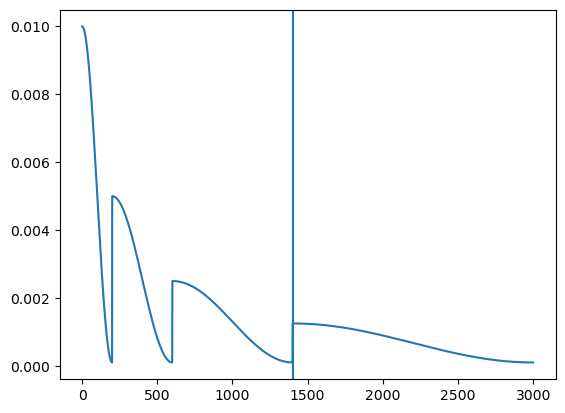

In [7]:
# epochs = []
# lrs = []
# optimizer = optim.LBFGS(model.parameters(), lr=1e-4)
# scheduler = CosineScheduler(
#     optimizer, lr_max=1e-2, period=200, warmup=0, lr_max_mult=0.5, period_mult=2.0
# )
# for epoch in range(3000):
#     epochs.append(epoch)
#     lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()
# plt.axvline(1400)
# plt.plot(epochs, lrs)

In [12]:
epochs = 1400

losses_ic: list[float] = []
losses_bc_value: list[float] = []
losses_bc_derivative: list[float] = []
losses_pde: list[float] = []
losses_data: list[float] = []
losses_train: list[float] = []
losses_test: list[float] = []

best_val_loss = 99999999.0
best_model_state_dict = copy.deepcopy(model.state_dict())

for epoch in trange(epochs):
    model.train()

    def closure() -> float:
        # Initial condition
        loss_ic = train_ic(model, ic_x, ic_y, ic_t, ic_field, num_ic, device, rng)

        # Boundary condition
        loss_bc_value, loss_bc_derivative = train_bc(model, bc_x1, bc_y1, bc_t1, bc_x2, bc_y2, bc_t2, num_bc, device, rng)

        # PDE, data condition
        loss_pde, loss_data = train_pde_data(model, pde_x, pde_y, pde_t, pde_field, num_pde, nu, device, rng)

        # Combining the loss functions
        loss = (
            1.0 * loss_ic
            + 1.0 * loss_bc_value
            + 1.0 * loss_bc_derivative
            + 1.0 * loss_pde
            + 0.0 * loss_data
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        return loss.item()

    optimizer.step(closure)
    scheduler.step()

    ########## Monitor ##########
    #  Initial condition
    loss_ic = train_ic(model, ic_x, ic_y, ic_t, ic_field, num_ic, device, rng)

    # Boundary condition
    loss_bc_value, loss_bc_derivative = train_bc(model, bc_x1, bc_y1, bc_t1, bc_x2, bc_y2, bc_t2, num_bc, device, rng)

    # PDE, data condition
    loss_pde, loss_data = train_pde_data(model, pde_x, pde_y, pde_t, pde_field, num_pde, nu, device, rng)

    # Combining the loss functions
    loss = (
        1.0 * loss_ic
        + 1.0 * loss_bc_value
        + 1.0 * loss_bc_derivative
        + 1.0 * loss_pde
        + 0.0 * loss_data
    )

    # Validation
    loss_val = validate(model, val_x, val_y, val_t, val_field, num_val, device, rng).item()

    losses_ic.append(loss_ic.item())
    losses_bc_value.append(loss_bc_value.item())
    losses_bc_derivative.append(loss_bc_derivative.item())
    losses_pde.append(loss_pde.item())
    losses_data.append(loss_data.item())
    losses_train.append(loss.item())
    losses_test.append(loss_val)

    # Save best model
    if loss_val >= best_val_loss:
        continue
    best_val_loss = loss_val
    best_model_state_dict = copy.deepcopy(model.state_dict())
    tqdm.write(f"{epoch}: train loss={loss.item():.4e}, val loss={loss_val:.4e}")

# Load best model state
last_model_state_dict = copy.copy(model.state_dict())
model.load_state_dict(best_model_state_dict)

  0%|          | 0/3000 [00:00<?, ?it/s]

0: train loss=1.1111e+00, val loss=3.1068e-01


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 2; 10.75 GiB total capacity; 9.78 GiB already allocated; 16.50 MiB free; 9.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.plot(losses_ic, label="ic")
ax1.plot(losses_bc_value, label="bc_value")
ax1.plot(losses_bc_derivative, label="bc_derivative")
ax1.plot(losses_pde, label="pde")
ax1.plot(losses_data, label="data")
ax1.plot(losses_train, label="train")

ax1.legend()
ax1.set_yscale("log")

ax2.plot(losses_test, label="test")
ax2.legend()

fig.tight_layout()
fig.show()